# CMPINF 0010 Final Project
## Best Neighborhoods and Routes for Getaway Crimes
#### Group Members: Dylan Jenny, Adam Wipprecht, Roy Wu

#### Imports

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import geopandas
import re
import json
import statistics

# haversine is used to properly calculate the distance between two coordinates
import haversine as hs

# imports to create a custom colormap
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

## Metric 1: Speed Bumps //Roy Wu
### Data from: https://data.wprdc.org/dataset/city-of-pittsburgh-speed-humps

According to the [FHWA Government course on transportation](https://safety.fhwa.dot.gov/ped_bike/univcourse/pdf/swless11.pdf), speed bumps (also known as "road humps") is a raised area in the roadway
pavement surface extending transversely across the roadway. Speed humps normally have a
minimum height of 3 to 4 inches and a travel length of approximately 12 feet, although these dimensions may vary. It is typically used as an effective traffic calming device that controls the speed of vehicles. They are refered to as "Silent Policemen", but they have their downsides. These downsides include a false sense of security for pedestrians, increased congestion and diversion of traffic, lack of proven design standards, liability issues, negative impact on bicyclers, and an increase in response time for emergency vehicles.

In the case of getaways, felons and nefarious individuals are **slowed down** when they have to deal with speed bumps.

In [2]:
speedbumps = pd.read_csv("row64speedbumpfiles/speedbumps.csv", index_col= "hump_id")

In [3]:
len(speedbumps)

79

This number represents the total amount of individual speedbumps in the city of Pittsburgh.

In [4]:
speedbumps['neighborhood'].value_counts().sort_values(ascending=True)

Overbrook               1
Central Oakland         1
Stanton Heights         1
Highland Park           2
Bloomfield              3
Mount Washington        3
South Side Flats        3
Squirrel Hill North     3
Garfield                3
Perry North             4
Homewood South          4
Brookline               4
Upper Hill              4
South Side Slopes       4
North Oakland           6
Polish Hill             6
Carrick                 9
Squirrel Hill South    18
Name: neighborhood, dtype: int64

This list shows the amount of speedbumps in the neighborhoods in the city of Pittsburgh.

In [5]:
speedbumps['locator_street'].value_counts().sort_values(ascending=True)

Summerset Dr      1
Black St          2
Darlington Rd     2
Heberton St       2
Mossfield St      2
Parkfield St      3
Edmond St         3
Spokane St        3
Grandview Ave     3
Muriel St         3
Maytide St        4
Jacob St          4
Webster Ave       4
Beechwood Blvd    4
Venture St        4
Mission St        4
Finance St        4
Parkview Blvd     5
Gold Way          5
Boundary St       5
Melwood Ave       6
Saline St         6
Name: locator_street, dtype: int64

This list shows the amount of speedbumps on each street in the neighborhoods in the city of Pittsburgh 

<AxesSubplot:ylabel='Density'>

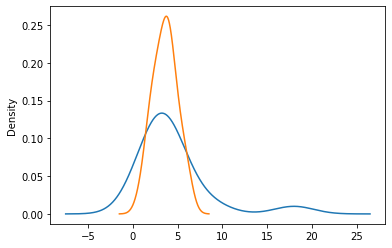

In [6]:
speedbumps['neighborhood'].value_counts().plot.density()
speedbumps['locator_street'].value_counts().plot.density()

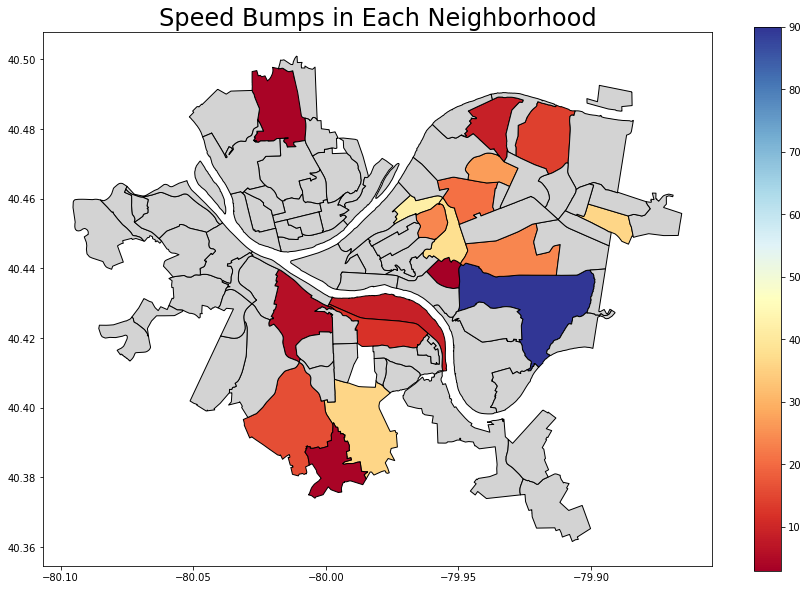

In [8]:
neighborhoods = geopandas.read_file("data/Neighborhoods/Neighborhoods_.shp")
speedbump_map = neighborhoods.merge(council_district, how='left', left_on='hood', right_on='neighborhood')
speedbump_map[['hood','council_district','geometry']].head()
fig_00, ax_00 = plt.subplots(figsize=(15, 10))
speedbump_map.plot(column='council_district',
                cmap='RdYlBu',
                edgecolor="black",
                legend=True, 
                figsize=(15, 10),
                missing_kwds={"color": "lightgrey"},
                ax=ax_00
               )
plt.title('Speed Bumps in Each Neighborhood', fontdict = {'fontsize': 24})
plt.show()

In [9]:
speedbump_map.explore(
     column="council_district", # make choropleth based on "BoroName" column
     tooltip=["hood", "council_district"], # show "BoroName" value in tooltip (on hover)
     popup=True, # show all values in popup (on click)
     tiles="CartoDB positron", # use "CartoDB positron" tiles
     cmap="RdYlBu", # use "Set1" matplotlib colormap
     # style_kwds=dict(color="black") # use black outline
     missing_kwds={"color": "lightgrey"},
    )

**Speedbump Metric Conclusion**

Keep in mind that this conclusion does not take into account anything more than just the location and amount of speedbumps. There is most definitely other deciding factors that are more appropriate for indicating the best neighborhood to be in for a criminal. 

A criminal needs an easy and quick getaway route to escape the crime scene or flee police. Naturally, speedbumps are a force against criminal activity and they can slow down their nefarious escape. A criminal would likely want to avoid areas with as much speedbumps as possible. This can also be logically correlated to the amount of surveillance and pedestrian or law enforcement activity in the area. The python code above first shows the total amount of speedbumps in all the neighborhoods of Pittsburgh. Then, it shows the amount of speedbumps in each neighborhood and the exact street. Keep in mind that many of the streets overlap into more than one neighborhood. In this case, Overbrook, Stanton Heights, and Central Oakland all share the lowest speedbump count of 1; making these neighborhoods the best for criminal getaways regarding the category of speedbumps. The greatest outlier is Squirrel Hill South, with a whopping 18 speedbumps. 

## Metric 2: Chances of being caught
### Data: https://data.wprdc.org/dataset/arrest-data

The WPRDC data set I chose to work with is Pittsburgh Police Arrest Data. It includes information from Pittsburgh Police about arrests from 2016 to current. Some of the fields it contains are: Incident Location (Neighborhood, Address, Coordinates), Arrest Location (Address Only), Time of Arrest, Demographics of Suspect (Age, Race, Gender), and Offenses/Crimes.

#### Create a custom quartile colormap based on the default "Pastel1"

In [10]:
BetterPastel1 = ListedColormap(np.mean( np.array([ cm.get_cmap('Pastel1', 9)(np.linspace(0, 1, 9)), cm.get_cmap('Set1', 9)(np.linspace(0, 1, 9)) ]), axis=0 ))
BetterPastel1_r = ListedColormap(np.mean( np.array([ cm.get_cmap('Pastel1_r', 9)(np.linspace(0, 1, 9)), cm.get_cmap('Set1_r', 9)(np.linspace(0, 1, 9)) ]), axis=0 ))

#### Load the initial data from a csv and the map data for Pittsburgh neighborhoods

In [11]:
df = pd.read_csv("data/arrest-data.csv")
neighborhoods = geopandas.read_file("data/Neighborhoods/Neighborhoods_.shp")

#### Example of Data Row

In [12]:
df.head(1)

,PK,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,OFFENSES,INCIDENTLOCATION,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y
0,1975272,16158872,42.0,F,B,2016-08-24T12:20:00,"4700 Block Centre AV Pittsburgh, PA 15213",3929 Retail Theft.,"4700 Block Centre AV Pittsburgh, PA 15213",Bloomfield,5,804.0,8.0,2.0,-79.949277,40.452551


## Arrests Over Time

One important factor for a getaway crimes is the amount of police presence in the area. With more police around, it is more likely to get caught. The first part of this analysis will try to measure that through the number of arrests in a neighborhood. Before looking into the trends of individual neighborhoods, it would be helpful to see general trends of the data.

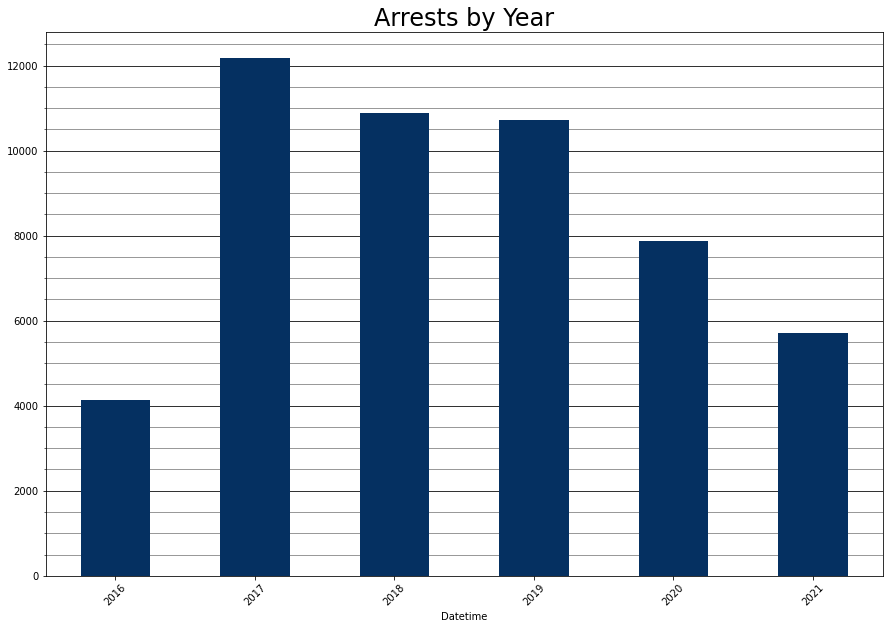

In [13]:
# Convert the arrest time into a workable datetime object
df['Datetime'] = pd.to_datetime(df['ARRESTTIME'])

# Filter out irregular data from before 2016 and group them by year
yearly_crime = df[(df['Datetime'] > '2015-12-31')].copy()
yearly_crime.index = yearly_crime['Datetime']
crime_groupby_year = yearly_crime.groupby(pd.Grouper(freq='Y')).count()

# Create a plot for the number of crimes in each year
fig1, ax1 = plt.subplots()
crime_groupby_year['OFFENSES'].plot(kind='bar', figsize=(15,10), ax=ax1, cmap='RdBu_r')
ax1.set_xticklabels([x.strftime("%Y") for x in crime_groupby_year.index], rotation=45)
ax1.set_axisbelow(True)
ax1.yaxis.grid(True, color ="black")
ax1.yaxis.grid(True, 'minor', color ="grey")
plt.minorticks_on()
ax1.xaxis.set_tick_params(which='minor', bottom=False)
plt.title('Arrests by Year', fontdict = {'fontsize': 24})
plt.show()

The number of arrests has decreased every year since 2017.

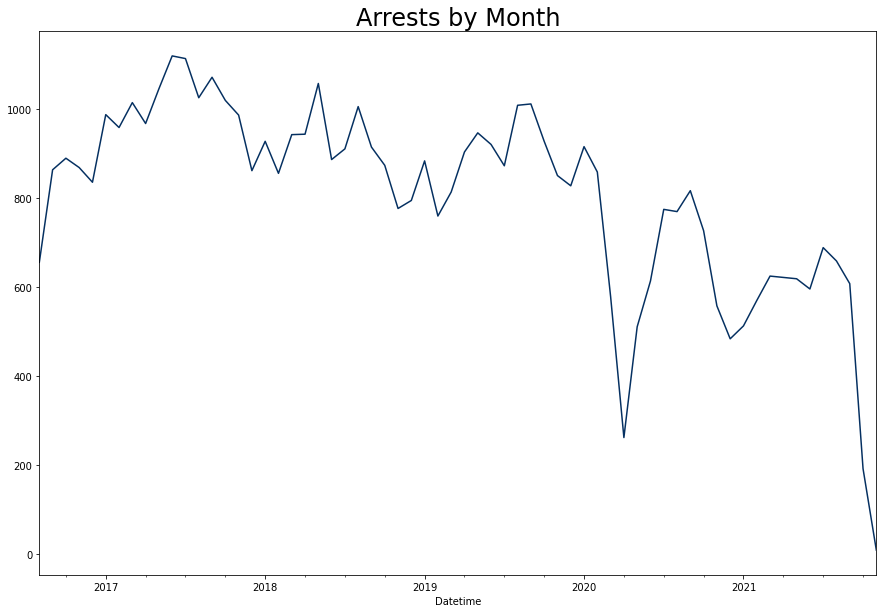

In [14]:
# Filter out irregular data from before 2016 and group them by month
monthly_crime = df[(df['Datetime'] > '2016-08-01')].copy()
monthly_crime.index = monthly_crime['Datetime']
crime_groupby_month = monthly_crime.groupby(pd.Grouper(freq='M')).count()

# Create a plot for the number of crimes in each month
fig2, ax2 = plt.subplots()
crime_groupby_month['OFFENSES'].plot.line(figsize=(15,10), ax = ax2, cmap='RdBu_r')
plt.title('Arrests by Month', fontdict = {'fontsize': 24})
plt.show()

This plot also supports the idea that crime (*or at least arrests*) have generally decreased in the past few years.

### Within the Past 6 Months

Now we will get into the evaluation of individual neighborhoods. In order to get a better idea of current statuses, we will only look at more recent arrest data. We will compare this time period to the one before it. For example, comparing January to June with July to December.

There are 3 metrics being used to evaluate each neighborhood:
1. A pure difference between the number of arrests. 
2. A ratio between the most recent period's number of arrests to both periods' number of arrests. 
3. The percent change from the most recent period from the previous period.

In [15]:
past_six_months = df[(df['Datetime'] > '2021-06-01')].groupby('INCIDENTNEIGHBORHOOD').count()
previous_past_six_mo = df[(df['Datetime'] > '2021-01-01') & (df['Datetime'] < '2021-06-01')].groupby('INCIDENTNEIGHBORHOOD').count()

previous_past_six_mo['six_mo_diff'] = previous_past_six_mo['OFFENSES'] - past_six_months['OFFENSES']
previous_past_six_mo['six_mo_ratio'] = previous_past_six_mo['OFFENSES']/(past_six_months['OFFENSES']+previous_past_six_mo['OFFENSES'])
previous_past_six_mo['six_mo_%change'] = (past_six_months['OFFENSES'] - previous_past_six_mo['OFFENSES']) / previous_past_six_mo['OFFENSES']

six_mo_map = neighborhoods.merge(previous_past_six_mo, how='left', left_on='hood', right_on='INCIDENTNEIGHBORHOOD')

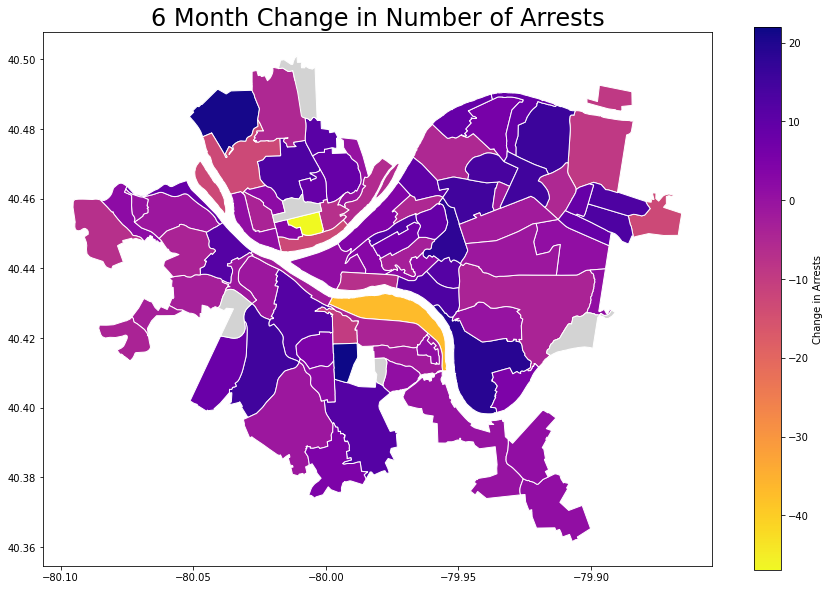

In [16]:
fig_3, ax_3 = plt.subplots(figsize=(15, 10))
six_mo_map.plot(column='six_mo_diff',
                cmap='plasma_r',
                edgecolor="white",
                legend=True, 
                legend_kwds={'label': "Change in Arrests"},
                figsize=(15, 10),
                missing_kwds={"color": "lightgrey"},
                ax=ax_3
               )
plt.title('6 Month Change in Number of Arrests', fontdict = {'fontsize': 24})
plt.show()

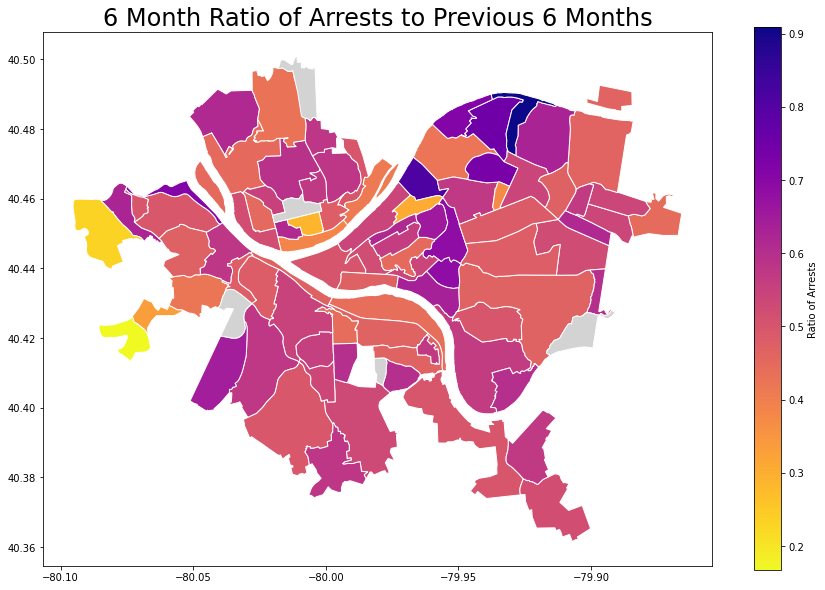

In [17]:
fig_4, ax_4 = plt.subplots(figsize=(15, 10))
six_mo_map.plot(column='six_mo_ratio',
                cmap='plasma_r',
                edgecolor="white",
                legend=True, 
                legend_kwds={'label': "Ratio of Arrests"},
                figsize=(15, 10),
                missing_kwds={"color": "lightgrey"},
                ax=ax_4
               )
plt.title('6 Month Ratio of Arrests to Previous 6 Months', fontdict = {'fontsize': 24})
plt.show()

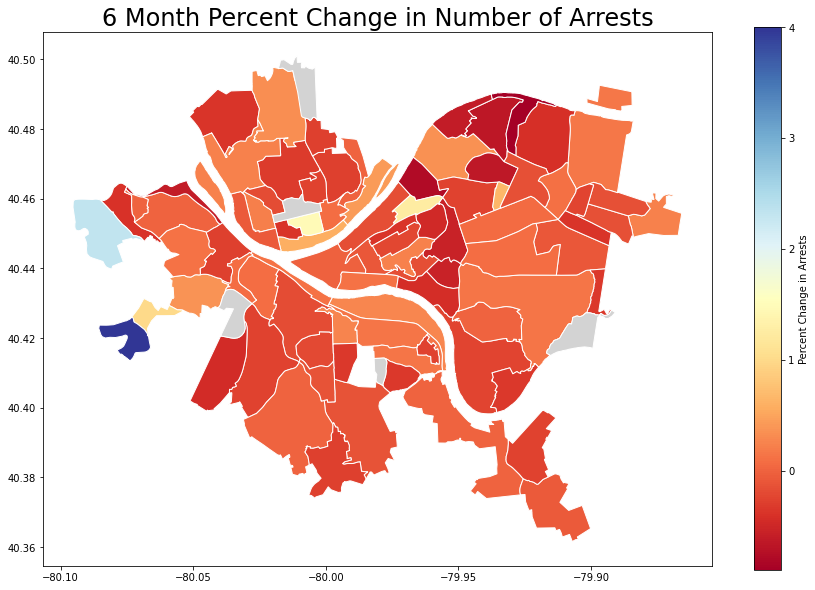

In [18]:
fig_5, ax_5 = plt.subplots(figsize=(15, 10))
six_mo_map.plot(column='six_mo_%change',
                cmap='RdYlBu',
                edgecolor="white",
                legend=True, 
                legend_kwds={'label': "Percent Change in Arrests"},
                figsize=(15, 10),
                missing_kwds={"color": "lightgrey"},
                ax=ax_5
               )
plt.title('6 Month Percent Change in Number of Arrests', fontdict = {'fontsize': 24})
plt.show()

### Within the past year

In [19]:
past_twelve_months = df[(df['Datetime'] > '2021-01-01')].groupby('INCIDENTNEIGHBORHOOD').count()
previous_past_12_mo = df[(df['Datetime'] > '2020-01-01') & (df['Datetime'] < '2021-01-01')].groupby('INCIDENTNEIGHBORHOOD').count()

previous_past_12_mo['12_mo_diff'] = previous_past_12_mo['OFFENSES'] - past_twelve_months['OFFENSES']
previous_past_12_mo['12_mo_ratio'] = previous_past_12_mo['OFFENSES']/(past_twelve_months['OFFENSES']+previous_past_12_mo['OFFENSES'])
previous_past_12_mo['12_mo_%change'] = (past_twelve_months['OFFENSES'] - previous_past_12_mo['OFFENSES']) / previous_past_12_mo['OFFENSES']
previous_past_12_mo['uh'] = previous_past_12_mo['12_mo_%change'].apply(lambda x: np.log(x + 1.0) if x >= 0 else -np.log(-x+1.0)) # - previous_past_six_mo['six_mo_%change'].mean()) / previous_past_six_mo['six_mo_%change'].std()

twelve_mo_map = neighborhoods.merge(previous_past_12_mo, how='left', left_on='hood', right_on='INCIDENTNEIGHBORHOOD')

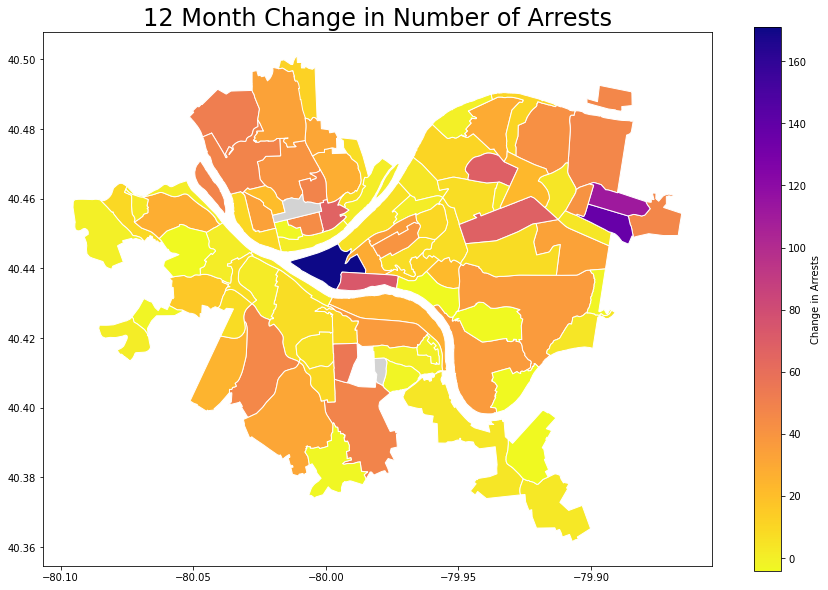

In [20]:
fig_7, ax_7 = plt.subplots(figsize=(15, 10))
twelve_mo_map.plot(column='12_mo_diff',
                cmap='plasma_r',
                edgecolor="white",
                legend=True, 
                legend_kwds={'label': "Change in Arrests"},
                figsize=(15, 10),
                missing_kwds={"color": "lightgrey"},
                ax=ax_7
               )
plt.title('12 Month Change in Number of Arrests', fontdict = {'fontsize': 24})
plt.show()

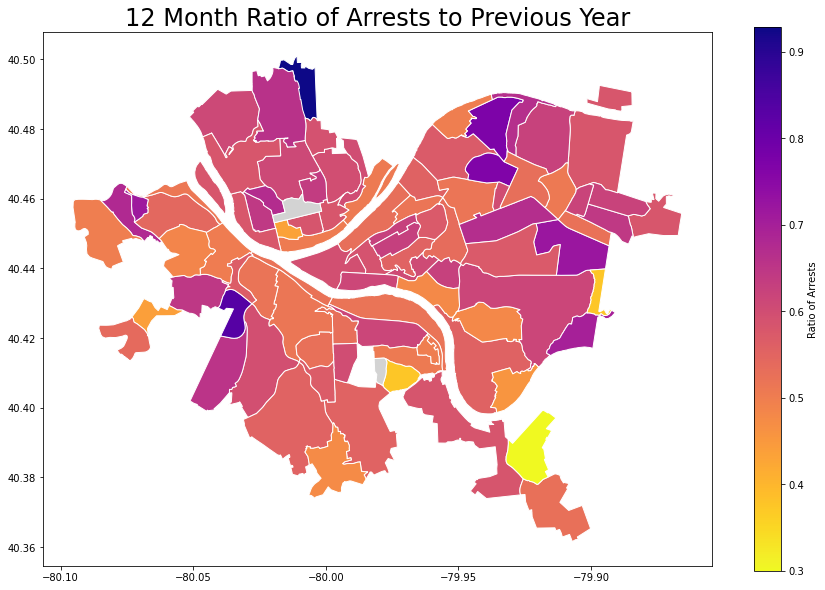

In [21]:
fig_8, ax_8 = plt.subplots(figsize=(15, 10))
twelve_mo_map.plot(column='12_mo_ratio',
                cmap='plasma_r',
                edgecolor="white",
                legend=True, 
                legend_kwds={'label': "Ratio of Arrests"},
                figsize=(15, 10),
                missing_kwds={"color": "lightgrey"},
                ax=ax_8
               )
plt.title('12 Month Ratio of Arrests to Previous Year', fontdict = {'fontsize': 24})
plt.show()

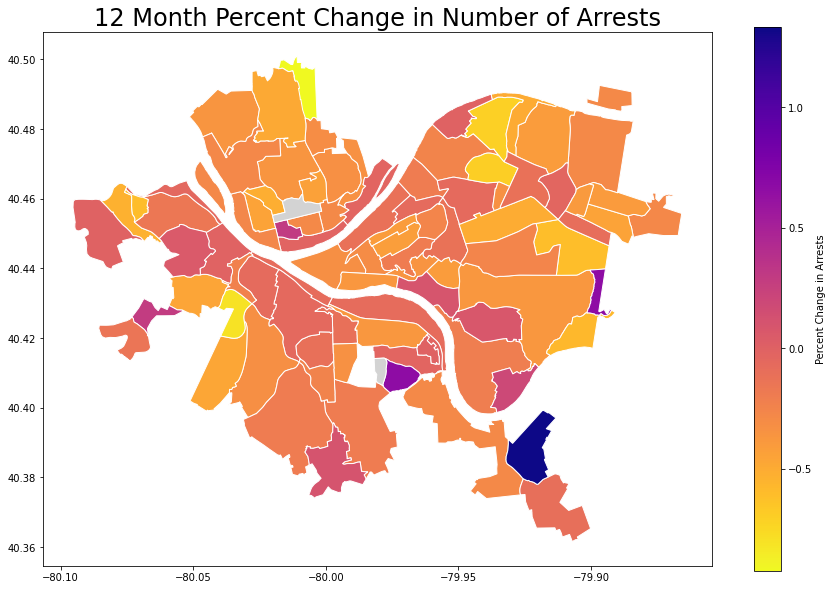

In [22]:
fig_9, ax_9 = plt.subplots(figsize=(15, 10))
twelve_mo_map.plot(column='12_mo_%change',
                cmap='plasma_r',
                edgecolor="white",
                legend=True, 
                legend_kwds={'label': "Percent Change in Arrests"},
                figsize=(15, 10),
                missing_kwds={"color": "lightgrey"},
                ax=ax_9
               )
plt.title('12 Month Percent Change in Number of Arrests', fontdict = {'fontsize': 24})
plt.show()

## Distance between Crime and Arrest

Another factor that can be considered from this data is the distance between the arrest location and the location where the crime ('incident') was committed. Although the best getaways are those where you do not get caught, getting further away from the crime is progress towards that goal.

Unfortunately, only the Incident Location's coordinates are included in the data. It also does not contain an entry for each address. Therefore, to get the coordinates for all arrest locations, an external API needed to be used. Most APIs either required payment or did not provide enough free queries to find the over 4000 unique missing addresses. I ended up using [Position Stack](https://positionstack.com/). There no great way to verify the correctness of the results.

Below is the code that was used to query the Position Stack API to attempt to get the missing coordinates from the addresses in the data.

```py
import http.client, urllib.parse
import time
from tqdm import tqdm
loc_data = {}
for unknown_address in tqdm(unknown_addresses):
    conn = http.client.HTTPConnection('api.positionstack.com')
    params = urllib.parse.urlencode({
        'access_key': '', # <== My private API would be here
        'query': unknown_address,
        'region': 'Pennsylvania',
        'json': 1,
    })

    conn.request('GET', '/v1/forward?{}'.format(params))

    res = conn.getresponse()
    data = res.read()
    
    loc_data[unknown_address] = data.decode('utf-8')
```

The data from those queries are stored in `geo_data.txt` as JSON data. Additionally, some points of interest were added by me manually, and are contained in `manual.txt` as a list of longitude and latitude values. 

#### Read in the Address Data

In [23]:
with open(r'data/geo_data.txt', 'r') as f:
    missing_addresses_raw = eval(f.read())
    
with open(r'data/manual.txt', 'r') as f:
    missing_addresses = eval(f.read())

#### Parse the JSON into the address map

In [24]:
for i in missing_addresses_raw:
    if i in missing_addresses:
        continue
    if missing_addresses_raw[i] == '' or missing_addresses_raw[i] == '<html><body><h1>503 Service Unavailable</h1>\nNo server is available to handle this request.\n</body></html>\n':
        continue
    loc_data = json.loads(missing_addresses_raw[i])['data']
    
    if not any(loc_data):
        continue
        
    conf = max([i['confidence'] for i in loc_data])
    confident_results = [i for i in loc_data if i['confidence'] == conf]
    x = statistics.median([i['longitude'] for i in confident_results])
    y = statistics.median([i['latitude'] for i in confident_results])
    missing_addresses[i] = [y,x]

#### Correct missing incident locations if possible, add the arrest location's longitude and latitude to the dataframe, and calculate the distance between them

In [25]:
df['AX'] = np.nan
df['AY'] = np.nan

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    if row['X'] == 0:
        address = row['INCIDENTLOCATION'].lower()
        if address in missing_addresses:
            df.at[index, 'X'] = missing_addresses[address][1]
            df.at[index, 'Y'] = missing_addresses[address][0]
    
    arrest_address = row['ARRESTLOCATION'].lower()
    
    if row['ARRESTLOCATION'] == row['INCIDENTLOCATION']:
        df.at[index, 'AX'] = df.at[index, 'X']
        df.at[index, 'AY'] = df.at[index, 'Y']
    elif arrest_address in missing_addresses:
        df.at[index, 'AX'] = missing_addresses[arrest_address][1]
        df.at[index, 'AY'] = missing_addresses[arrest_address][0]
        
    if pd.notna(df.at[index, 'X']) and df.at[index, 'X'] != 0:
        coor1 = (df.at[index, 'X'], df.at[index, 'Y'])
        coor2 = (df.at[index, 'AX'], df.at[index, 'AY'])
        if 0 in coor1 or 0 in coor2:
            df.at[index, 'dist'] = np.nan
        else:
            df.at[index, 'dist'] = hs.haversine(coor1, coor2)

100%|██████████████████████████████| 51566/51566 [00:22<00:00, 2246.87it/s]


### Summary of the Distance Results

In [26]:
df_map = neighborhoods.merge(df, how='left', left_on='hood', right_on='INCIDENTNEIGHBORHOOD')

In [27]:
median_dist_df = df.groupby('INCIDENTNEIGHBORHOOD').median()
median_dist_map = neighborhoods.merge(median_dist_df, how='left', left_on='hood', right_on='INCIDENTNEIGHBORHOOD')

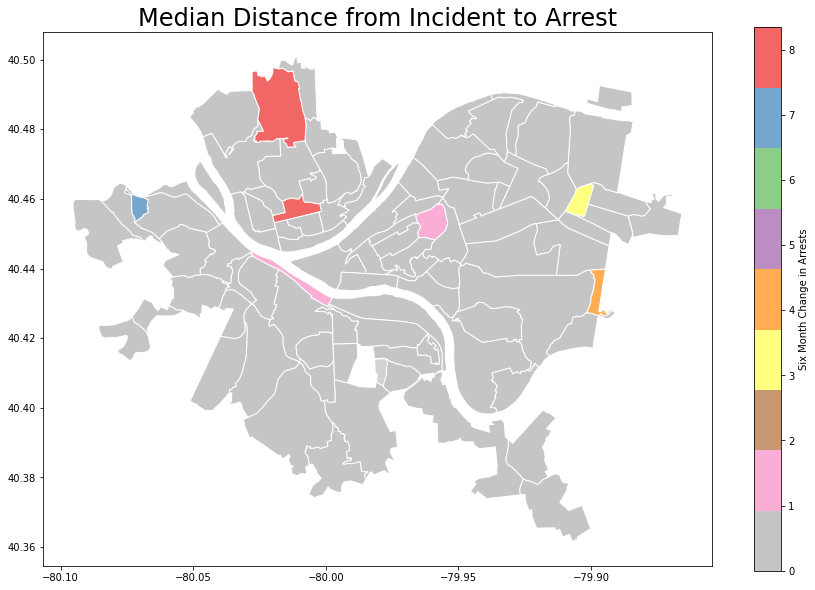

In [28]:
fig_01, ax_01 = plt.subplots(figsize=(15, 10))
median_dist_map.plot(column='dist',
                cmap=BetterPastel1_r,
                edgecolor="white",
                legend=True, 
                legend_kwds={'label': "Six Month Change in Arrests"},
                figsize=(15, 10),
                missing_kwds={"color": "lightgrey"},
                ax=ax_01
               )
plt.title('Median Distance from Incident to Arrest', fontdict = {'fontsize': 24})
plt.show()

In [29]:
mean_dist_df = df.groupby('INCIDENTNEIGHBORHOOD').mean()
mean_dist_map = neighborhoods.merge(mean_dist_df, how='left', left_on='hood', right_on='INCIDENTNEIGHBORHOOD')

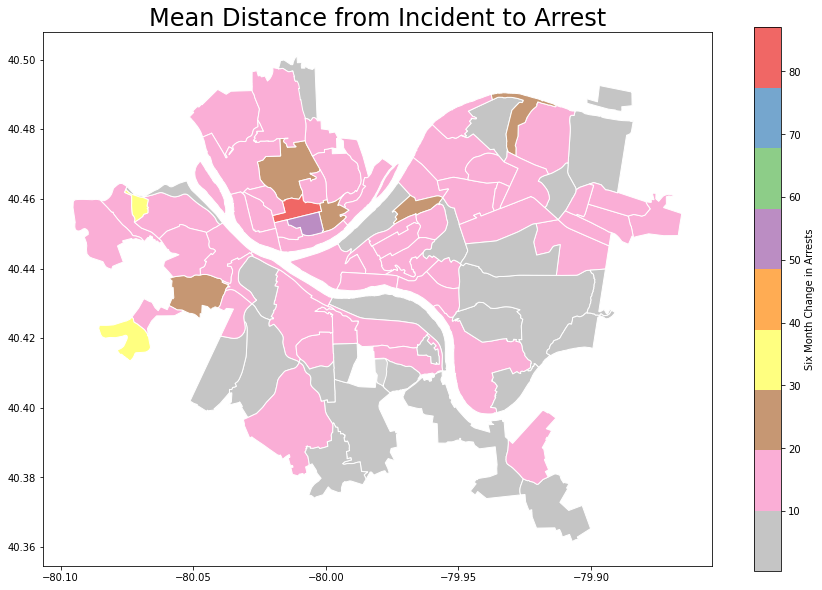

In [30]:
fig_02, ax_02 = plt.subplots(figsize=(15, 10))
mean_dist_map.plot(column='dist',
                cmap=BetterPastel1_r,
                edgecolor="white",
                legend=True, 
                legend_kwds={'label': "Six Month Change in Arrests"},
                figsize=(15, 10),
                missing_kwds={"color": "lightgrey"},
                ax=ax_02
               )
plt.title('Mean Distance from Incident to Arrest', fontdict = {'fontsize': 24})
plt.show()

In [31]:
max_dist_df = df.groupby('INCIDENTNEIGHBORHOOD').max()
max_dist_map = neighborhoods.merge(max_dist_df, how='left', left_on='hood', right_on='INCIDENTNEIGHBORHOOD')

<ipython-input-31-8835e0f9ffd7>:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  max_dist_df = df.groupby('INCIDENTNEIGHBORHOOD').max()


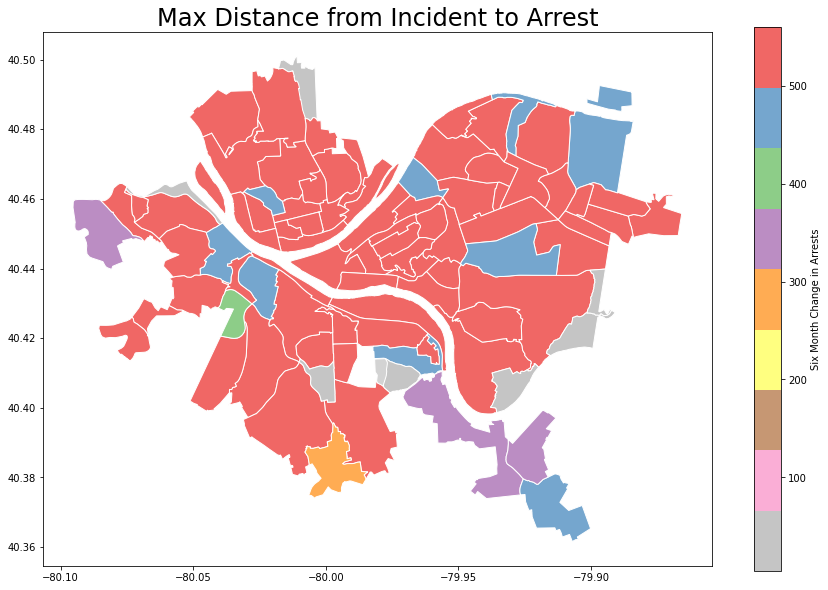

In [32]:
fig_03, ax_03 = plt.subplots(figsize=(15, 10))
max_dist_map.plot(column='dist',
                cmap=BetterPastel1_r,
                edgecolor="white",
                legend=True, 
                legend_kwds={'label': "Six Month Change in Arrests"},
                figsize=(15, 10),
                missing_kwds={"color": "lightgrey"},
                ax=ax_03
               )
plt.title('Max Distance from Incident to Arrest', fontdict = {'fontsize': 24})
plt.show()

In [33]:
std_dist_df = df.groupby('INCIDENTNEIGHBORHOOD').std()
std_dist_map = neighborhoods.merge(std_dist_df, how='left', left_on='hood', right_on='INCIDENTNEIGHBORHOOD')

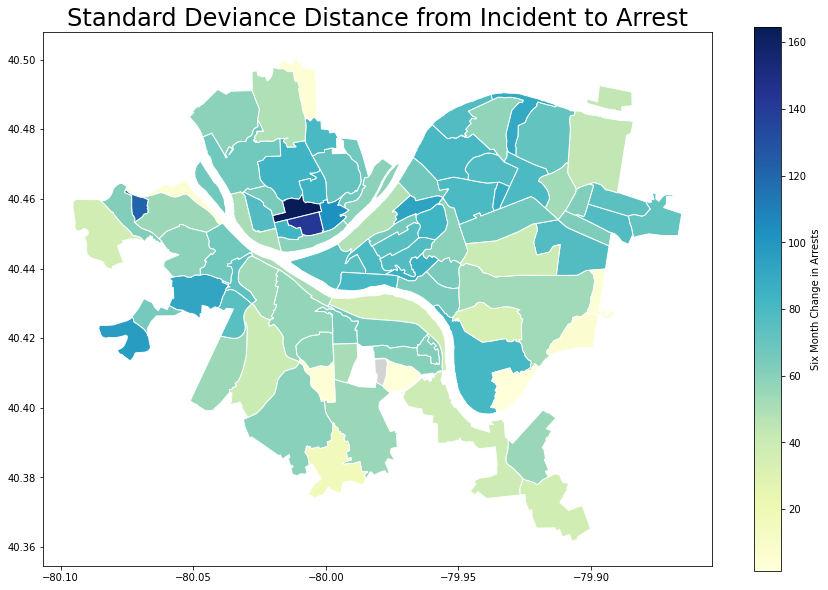

In [34]:
fig_04, ax_04 = plt.subplots(figsize=(15, 10))
std_dist_map.plot(column='dist',
                cmap='YlGnBu',
                edgecolor="white",
                legend=True, 
                legend_kwds={'label': "Six Month Change in Arrests"},
                figsize=(15, 10),
                missing_kwds={"color": "lightgrey"},
                ax=ax_04
               )
plt.title('Standard Deviance Distance from Incident to Arrest', fontdict = {'fontsize': 24})
plt.show()

#### Determine the 10 best and worst performing neighborhoods from those summary statistics

In [35]:
top_10 = set()
n = 9

while(len(top_10) < 10):
    n += 1
    l1 = list(median_dist_map[median_dist_map['dist'] <= max(median_dist_map.nsmallest(n, 'dist')['dist'])]['hood'])
    l2 = list(mean_dist_map[mean_dist_map['dist'] <= max(mean_dist_map.nsmallest(n, 'dist')['dist'])]['hood'])
    l3 = list(max_dist_map[max_dist_map['dist'] <= max(max_dist_map.nsmallest(n, 'dist')['dist'])]['hood'])
    l4 = list(std_dist_map[std_dist_map['dist'] <= max(std_dist_map.nsmallest(n, 'dist')['dist'])]['hood'])
    
    for i in df_map['hood']:
        if i in l1 and i in l2 and i in l3 and i in l4:
            top_10.add(i)

In [36]:
bottom_10 = set()
n = 9
while(len(bottom_10) < 10):
    n += 1
    l1 = list(median_dist_map[median_dist_map['dist'] >= min(median_dist_map.nlargest(n, 'dist')['dist'])]['hood'])
    l2 = list(mean_dist_map[mean_dist_map['dist'] >= min(mean_dist_map.nlargest(n, 'dist')['dist'])]['hood'])
    l3 = list(max_dist_map[max_dist_map['dist'] >= min(max_dist_map.nlargest(n, 'dist')['dist'])]['hood'])
    l4 = list(std_dist_map[std_dist_map['dist'] >= min(std_dist_map.nlargest(n, 'dist')['dist'])]['hood'])
    
    for i in df_map['hood']:
        if i in l1 and i in l2 and i in l3 and i in l4:
            bottom_10.add(i)

In [37]:
df['top'] = None
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    if df.at[index, 'INCIDENTNEIGHBORHOOD'] in top_10:
        df.at[index, 'top'] = True
    elif df.at[index, 'INCIDENTNEIGHBORHOOD'] in bottom_10:
        df.at[index, 'top'] = False
    else:
        df.at[index, 'top'] = None

100%|██████████████████████████████| 51566/51566 [00:10<00:00, 4809.41it/s]


In [38]:
top_bottom_df = df[pd.notna(df['top'])]
top_bottom_map = neighborhoods.merge(top_bottom_df, how='left', left_on='hood', right_on='INCIDENTNEIGHBORHOOD')

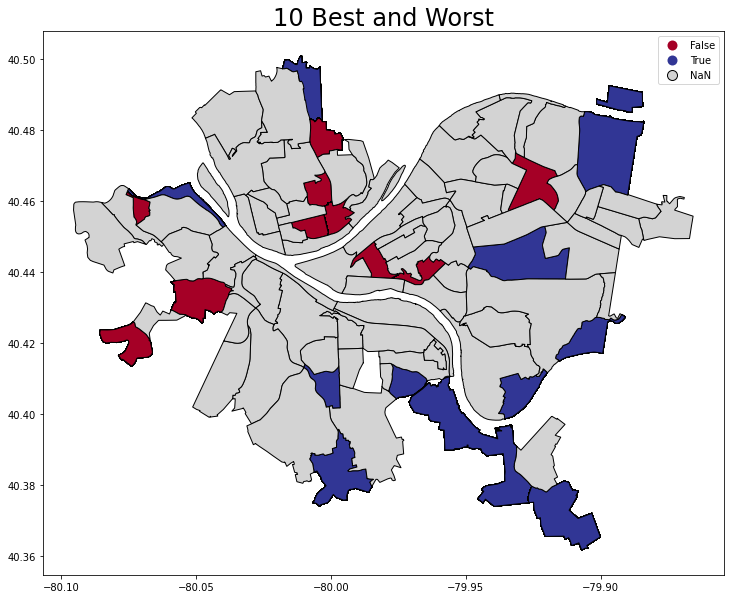

In [39]:
fig_05, ax_05 = plt.subplots(figsize=(15, 10))
top_bottom_map.plot(column='top',
                cmap='RdYlBu',
                edgecolor="black",
                legend=True, 
                figsize=(15, 10),
                missing_kwds={"color": "lightgrey"},
                ax=ax_05
               )
plt.title('10 Best and Worst', fontdict = {'fontsize': 24})
plt.show()

#### Create a boxplot for the distances in the 10 best and worst neighborhoods

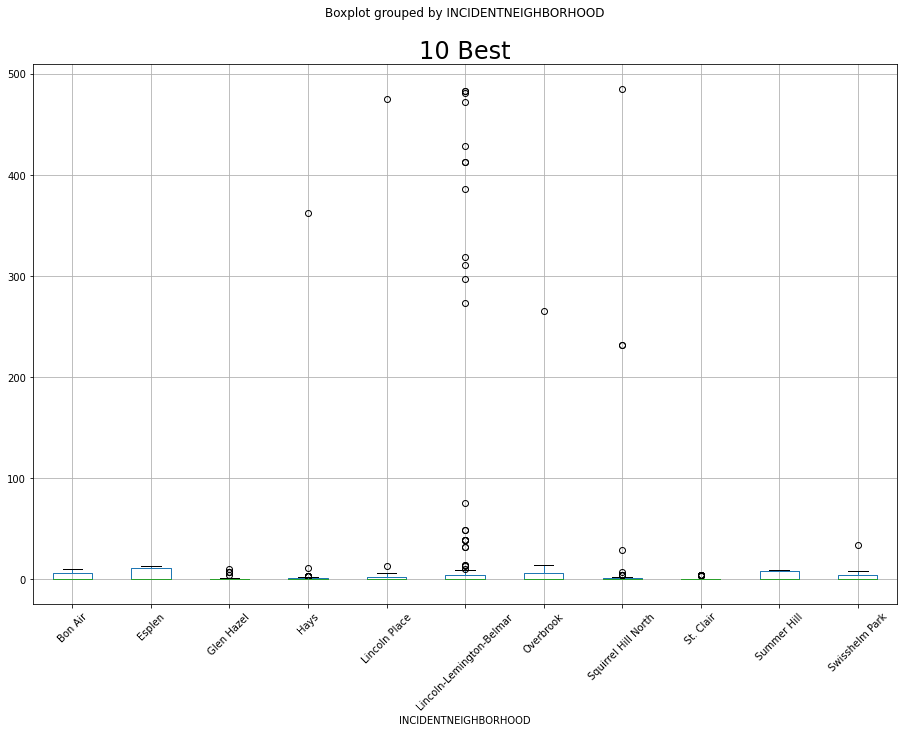

In [40]:
top_10_df = df.loc[(df['top'] == True)].copy()
fig_09, ax_09 = plt.subplots(figsize=(15, 10))
top_10_df.boxplot(column=['dist'], by='INCIDENTNEIGHBORHOOD', ax = ax_09)
plt.title('10 Best', fontdict = {'fontsize': 24})
plt.xticks(rotation=45)
plt.show()

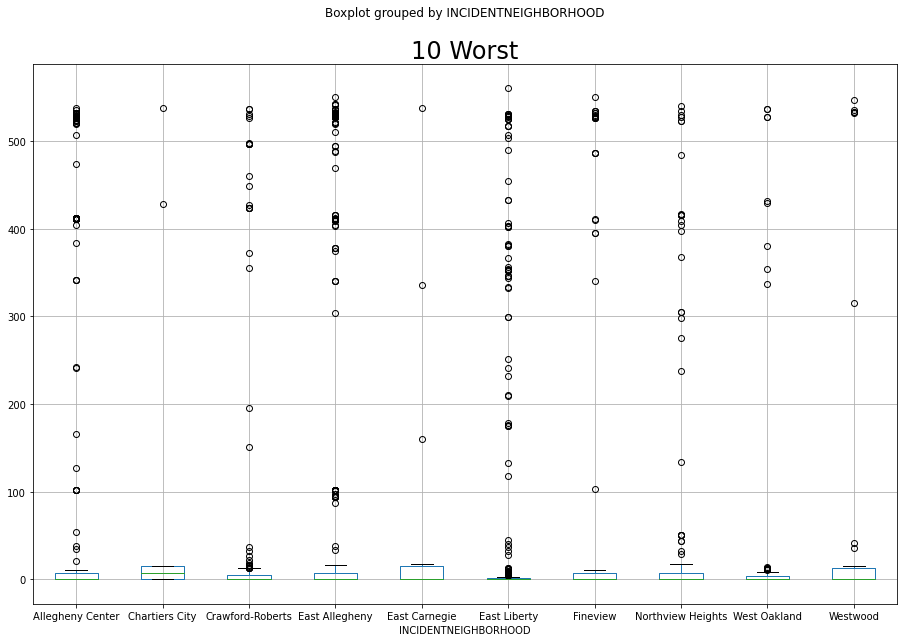

In [41]:
bottom_10_df = df.loc[df['top'] == False].copy()
fig_10, ax_10 = plt.subplots(figsize=(15, 10))
bottom_10_df.boxplot(column=['dist'], by='INCIDENTNEIGHBORHOOD', ax = ax_10)
plt.title('10 Worst', fontdict = {'fontsize': 24})
plt.show()

## Conclusion

Based on the high number of speed bumps and the performance of arrests, we believe Squirrel Hill to be the best neighborhood in Pittsburgh.